In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andcrls","key":"6985523622f8834aceff3648d70de82f"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d mexwell/crop-diseases-classification -p  /content/drive/MyDrive/Davi/Datasetcrop

Dataset URL: https://www.kaggle.com/datasets/mexwell/crop-diseases-classification
License(s): other
100% 1.99G/2.00G [00:32<00:00, 57.5MB/s]
100% 2.00G/2.00G [00:32<00:00, 65.1MB/s]


In [7]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Davi/Datasetcrop/crop-diseases-classification.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/Davi/Datasetcrop/')
os.remove(zip_path)

# Overview

## Dataset
Será utilizado este [dataset](https://www.kaggle.com/datasets/mexwell/crop-diseases-classification) para trabalhar com um problema de classificação multiclasses

# Imports

- Importando as bibliotecas necessárias:
    - `pandas` é importado para manipulação de dados.
    - `matplotlib.pyplot` é importado para visualização de dados.
    - `seaborn` é importado para visualização estatística de dados.
    - `train_test_split` é importado de `sklearn.model_selection` para dividir os dados em conjuntos de treinamento e teste.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torchvision import transforms
import random
import os
import pandas as pd
import numpy as np
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

# Análise exploratória de dados

Antes de definir o que iremos fazer sobre os dados, será feito uma análise exploratória inicial. Para isso, vamos entender melhor os dados.
- Carregando os dados:
    - `pd.read_csv()` é usado para ler o arquivo CSV que contém os dados.
    - O caminho para o arquivo CSV é "/kaggle/input/crop-diseases-classification/Data/train.csv".
    - Os dados são armazenados em um DataFrame chamado `dsDiseases`.

In [3]:
dsDiseases = pd.read_csv("/content/drive/MyDrive/Davi/Datasetcrop/Data/train.csv")

In [4]:
dir0='/content/drive/MyDrive/Davi/Datasetcrop/Data/train_images'

class_names=[0,1,2,3,4]
image_ids=dsDiseases['image_id'].tolist()
dsDiseases['path']=dsDiseases['image_id'].apply(lambda x:os.path.join(dir0,x))
display(dsDiseases)
print(len(dsDiseases))

,image_id,label,path
0,157078263.jpg,3,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
1,1574893536.jpg,3,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
2,1575013487.jpg,3,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
3,1576606254.jpg,0,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
4,1579761476.jpg,1,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
...,...,...,...
19167,1579761476_aug_157.jpg,1,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
19168,1579761476_aug_158.jpg,1,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
19169,1579761476_aug_159.jpg,1,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...
19170,1579761476_aug_160.jpg,1,/content/drive/MyDrive/Davi/Datasetcrop/Data/t...


19172


In [ ]:
files=[]
paths=[]
for dirname, _, filenames in os.walk(dir0):
    for filename in filenames:
        paths+=[(os.path.join(dirname, filename))]
        files+=[filename]
print(len(paths))

In [ ]:
drops=[]
for i in range(len(dsDiseases)):
    if dsDiseases.iloc[i,0] not in files:
        drops+=[i]
dsDiseases=dsDiseases.drop(drops,axis=0).reset_index(drop=True)
display(dsDiseases)

Nessa primeira parte, vamos entender o que é cada coluna:
- Examinando as primeiras linhas do DataFrame:
    - `head()` é usado para visualizar as primeiras linhas do DataFrame `dsDiseases`.
    - Isso ajuda a ter uma ideia inicial da estrutura e dos dados presentes no DataFrame.

In [4]:
dsDiseases.head()

,image_id,label
0,157078263.jpg,3
1,1574893536.jpg,3
2,1575013487.jpg,3
3,1576606254.jpg,0
4,1579761476.jpg,1


Para uma visão ampla em relação aos dados, podemos plotar dois gráficos: um gráfico em barras (com a contagem de cada categoria) e um gráfico em pizza (com a porcentagem das categorias).
- Contagem e visualização das categorias:
    - `value_counts()` é usado para contar o número de ocorrências de cada categoria na coluna 'label' do DataFrame `dsDiseases`.
    - Os resultados são armazenados na variável `counts`.
    - Um gráfico de barras é criado usando `sns.barplot()` para visualizar a contagem de cada categoria.
    - `counts.index` é usado como os valores no eixo x (categorias).
    - `counts.values` é usado como os valores no eixo y (contagem).
    - O título do gráfico é definido como 'Crop diseases'.
    - Os rótulos dos eixos x e y são definidos como 'Categorias' e 'Contagem', respectivamente.
    - `plt.show()` é usado para exibir o gráfico.

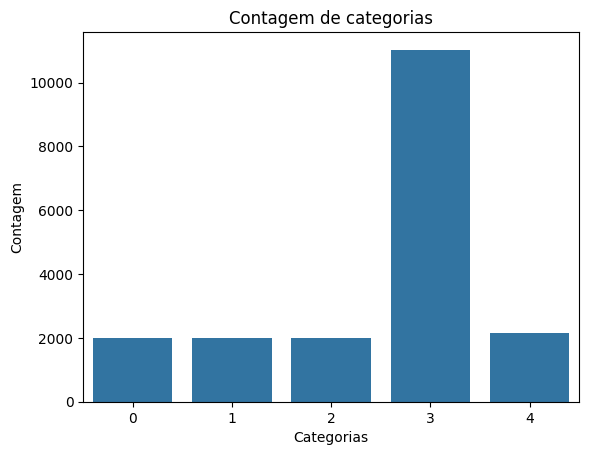

In [8]:
# Contagem das categorias
counts = dsDiseases['label'].value_counts()

# Plot
sns.barplot(x=counts.index, y=counts.values)
plt.title('Contagem de categorias')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

- Visualização das categorias em um gráfico de pizza:
    - `plt.pie()` é usado para criar um gráfico de pizza com as porcentagens de cada categoria.
    - `counts` é passado como os dados para o gráfico de pizza.
    - `labels=counts.index` é usado para rotular as fatias do gráfico de acordo com as categorias.
    - `autopct='%1.1f%%'` formata as porcentagens exibidas em cada fatia.
    - `startangle=140` define o ângulo inicial da pizza para uma melhor visualização.
    - `plt.title()` define o título do gráfico como 'Crop diseases'.
    - `plt.axis('equal')` garante que a pizza seja desenhada como um círculo.
    - `plt.show()` é usado para exibir o gráfico de pizza.

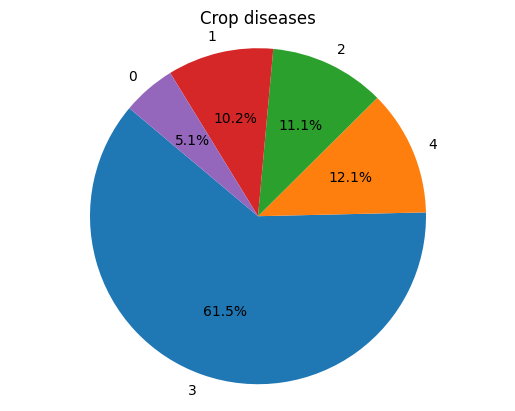

In [15]:
# Plot
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Crop diseases')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Divisão de treino, teste e validação

Bom, após vizualizarmos ambos os gráficos, percebemos que está desbalanceado, pois a categoria 3 possui 61.5% de amostras, o que é um valor maior do que a soma de todas as outras categorias, isso para um dataset não é bom, por isso vamos para a etapa de Divisão de treino, teste e validação de dados para o nosso dataset.

In [5]:
# Divisão dos dados em conjuntos de treinamento e teste, mantendo as amostras proporcionais
train_data, test_data = train_test_split(dsDiseases, test_size=0.2, random_state=42, stratify=dsDiseases['label'])

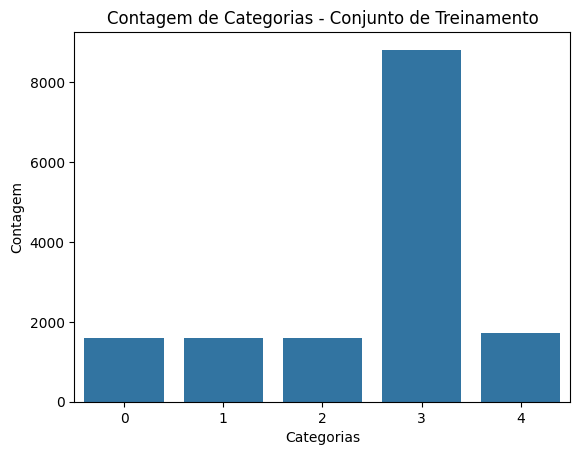

In [10]:
# Plot dos dados de treinamento
sns.barplot(x=train_data['label'].value_counts().index, y=train_data['label'].value_counts().values)
plt.title('Contagem de Categorias - Conjunto de Treinamento')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

In [2]:
train_data.head()

NameError: name 'train_data' is not defined

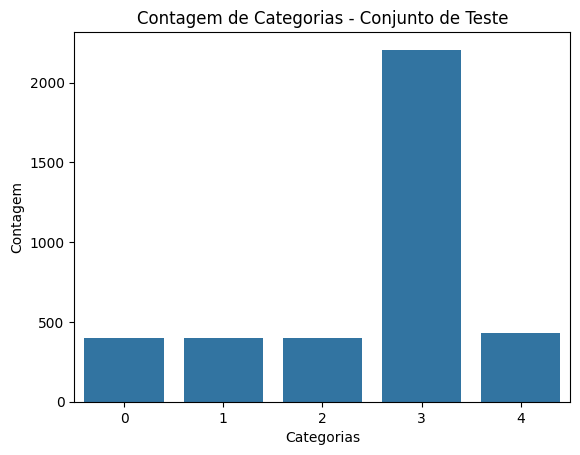

In [64]:
# Plot dos dados de teste
sns.barplot(x=test_data['label'].value_counts().index, y=test_data['label'].value_counts().values)
plt.title('Contagem de Categorias - Conjunto de Teste')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

In [65]:
# Contar amostras por classe
count_per_class = train_data['label'].value_counts()
print("Contagem de amostras por classe antes de balancear:", count_per_class)

Contagem de amostras por classe antes de balancear: label
3    8821
4    1733
0    1595
2    1594
1    1594
Name: count, dtype: int64


# Tratamento de dados

Técnicas de pré processamento acontecem dentro do dataset, antes de passar para o modelo, para que o dataset fique balanceado e tanto ele quanto o resultado seja justo.

Task:
Objetivo: Deixar todas as classes com a mesma quantidade. Aqui iremos deixar todas com o mesmo valor da classe 2, por ser a mediana.

- Classe 3 e 4: Recorte de dataset
    
    Será eliminado, de maneira aleatória, (classe3 - classe2) quantidades
    
    Motivo: Para diminuir a quantidade

- Classes 0 e 1: Data augmentation
   
    Motivo: Todas essas duas classes possuem uma amostragem muito menor. Sendo assim, iremos aumentar, através de técnicas de rotação e iluminação, os dados dessas classes. Com isso, teremos a mesma quantidade de dados da classe 2

## Treino

## Lidando com a classe 3 e 4

### Classe 3

In [6]:
import pandas as pd

while len(train_data[train_data['label'] == 3]) > len(train_data[train_data['label'] == 2]):
    index_to_drop = train_data[train_data['label'] == 3].index[0]
    train_data = train_data.drop(index_to_drop)


### Classe 4

In [7]:
import pandas as pd

while len(train_data[train_data['label'] == 4]) > len(train_data[train_data['label'] == 2]):
    index_to_drop = train_data[train_data['label'] == 4].index[0]
    train_data = train_data.drop(index_to_drop)

Conferindo o resultado

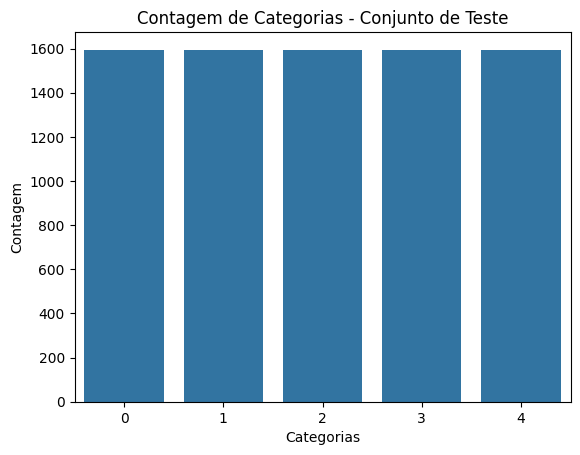

In [13]:
sns.barplot(x=train_data['label'].value_counts().index, y=train_data['label'].value_counts().values)
plt.title('Contagem de Categorias - Conjunto de Teste')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

In [14]:
# Contar amostras por classe
count_per_class = train_data['label'].value_counts()
print("Contagem de amostras por classe antes de balancear:", count_per_class)

Contagem de amostras por classe antes de balancear: label
0    1595
2    1594
1    1594
4    1594
3    1594
Name: count, dtype: int64


## Lidando com as classes 0 e 1

Para fazer este data augmentation, você deverá lidar com as seguintes questões:
- Onde salvar as imagens novas
- Acrescentar elas no CSV

Processo indicado:
1. Criar uma pasta
2. Transferir todas as imagens de /kaggle/input/crop-diseases-classification/Data/train_images para a nova pasta
3. Fazer o data augmentation
4. Adicionar o nome das novas imagens e a classe no CSV


## Classe 0

In [34]:


image_path = '/content/drive/MyDrive/Davi/Datasetcrop/Data/train_images'
csv_path = '/content/drive/MyDrive/Davi/Datasetcrop/Data/train.csv'

df = pd.read_csv(csv_path)

df = df[df['image_id'].apply(lambda x: os.path.exists(os.path.join(image_path, x)))]

class_0 = df[df['label'] == 0]

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Número de imagens a gerar
num_new_images = len(train_data[train_data['label'] == 2]) - len(train_data[train_data['label'] == 0]) #215

# Contador para novas imagens
new_images_count = 0

# Gerar novas imagens
for index, row in tqdm(class_0.iterrows()):
    img_path = os.path.join(image_path, row['image_id'])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        img = img.convert('RGB')
        x = np.array(img)
        x = x.reshape((1,) + x.shape)

        # Gerar novas imagens
        for batch in tqdm(datagen.flow(x, batch_size=1)):
            new_image = Image.fromarray(batch[0].astype('uint8'), 'RGB')
            new_image_id = f"{row['image_id'].split('.')[0]}_aug_{new_images_count}.jpg"
            new_image.save(os.path.join(image_path, new_image_id))
            new_row = pd.DataFrame({'image_id': [new_image_id], 'label': [0]})
            df = pd.concat([df, new_row], ignore_index=True)
            new_images_count += 1

            if new_images_count >= num_new_images:
                break
        if new_images_count >= num_new_images:
            break

df.to_csv(csv_path, index=False)


0it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<00:00,  3.85it/s]
2it [00:00,  4.15it/s]                       
3it [00:00,  4.05it/s]
4it [00:01,  3.67it/s]
5it [00:01,  3.72it/s]
6it [00:01,  3.75it/s]
7it [00:01,  3.77it/s]
8it [00:02,  3.12it/s]
9it [00:02,  2.80it/s]
10it [00:03,  2.78it/s]
11it [00:03,  2.83it/s]
12it [00:03,  2.65it/s]
13it [00:04,  2.58it/s]
14it [00:04,  2.50it/s]
15it [00:05,  2.39it/s]
16it [00:05,  2.20it/s]
17it [00:06,  2.19it/s]
18it [00:06,  2.44it/s]
19it [00:06,  2.42it/s]
20it [00:07,  2.51it/s]
21it [00:07,  2.44it/s]
22it [00:08,  2.45it/s]
23it [00:08,  2.39it/s]
24it [00:08,  2.45it/s]
25it [00:09,  2.68it/s]
26it [00:09,  2.98it/s]
27it [00:09,  3.20it/s]
28it [00:09,  3.44it/s]
29it [00:10,  3.49it/s]
30it [00:10,  3.59it/s]
31it [00:10,  3.52it/s]
32it [00:11,  3.65it/s]
33it [00:11,  3.80it/s]
34it [00:11,  3.96it/s]
35it [00:11,  3.91it/s]
36it [00:11,  4.02it/s]
37it [00:12,  4.00it/s]
38it [00:12,  4.00it/s]
39it [00:12,  3.86it/s]
40it [00

In [35]:
# Contar amostras por classe
count_per_class = df['label'].value_counts()
print("Contagem de amostras por classe antes de balancear:", count_per_class)

Contagem de amostras por classe antes de balancear: label
3    11027
4     2166
0     1993
2     1993
1     1831
Name: count, dtype: int64


## Classe 1

In [36]:
class_1 = df[df['label'] == 1]

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Número de imagens a gerar
num_new_images = len(train_data[train_data['label'] == 2]) - len(train_data[train_data['label'] == 1])  # 162

# Contador para novas imagens
new_images_count = 0

# Gerar novas imagens
for index, row in tqdm(class_1.iterrows(), total=class_1.shape[0]):
    img_path = os.path.join(image_path, row['image_id'])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        img = img.convert('RGB')
        x = np.array(img)
        x = x.reshape((1,) + x.shape)

        # Gerar novas imagens
        for batch in tqdm(datagen.flow(x, batch_size=1), total=num_new_images):
            new_image = Image.fromarray(batch[0].astype('uint8'), 'RGB')
            new_image_id = f"{row['image_id'].split('.')[0]}_aug_{new_images_count}.jpg"
            new_image.save(os.path.join(image_path, new_image_id))
            new_row = pd.DataFrame({'image_id': [new_image_id], 'label': [1]})
            df = pd.concat([df, new_row], ignore_index=True)
            new_images_count += 1

            if new_images_count >= num_new_images:
                break
        if new_images_count >= num_new_images:
            break

df.to_csv(csv_path, index=False)

  0%|          | 0/1831 [00:33<?, ?it/s]


In [37]:
count_per_class = df['label'].value_counts()
print("Contagem de amostras por classe antes de balancear:", count_per_class)

Contagem de amostras por classe antes de balancear: label
3    11027
4     2166
0     1993
1     1993
2     1993
Name: count, dtype: int64


## Teste

### Classe 3

In [9]:
import pandas as pd

while len(test_data[test_data['label'] == 3]) > len(test_data[test_data['label'] == 2]):
    index_to_drop = test_data[test_data['label'] == 3].index[0]
    test_data = test_data.drop(index_to_drop)

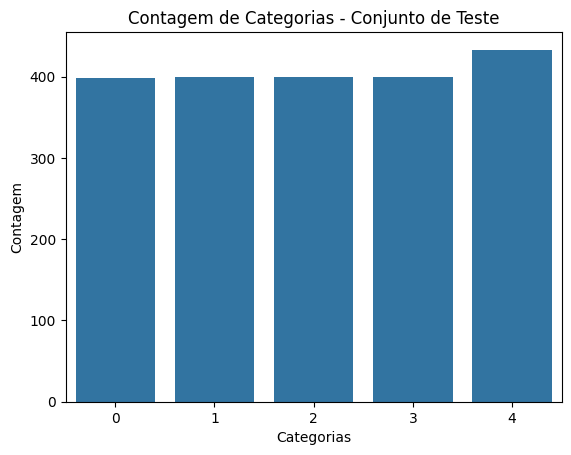

In [16]:
sns.barplot(x=test_data['label'].value_counts().index, y=test_data['label'].value_counts().values)
plt.title('Contagem de Categorias - Conjunto de Teste')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

### Classe 4

In [8]:
import pandas as pd

while len(test_data[test_data['label'] == 4]) > len(test_data[test_data['label'] == 2]):
    index_to_drop = test_data[test_data['label'] == 4].index[0]
    test_data = test_data.drop(index_to_drop)

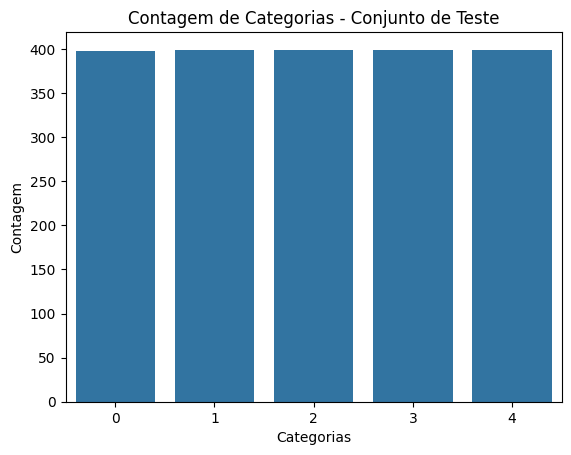

In [18]:
sns.barplot(x=test_data['label'].value_counts().index, y=test_data['label'].value_counts().values)
plt.title('Contagem de Categorias - Conjunto de Teste')
plt.xlabel('Categorias')
plt.ylabel('Contagem')
plt.show()

In [19]:
# Contar amostras por classe
count_per_class = test_data['label'].value_counts()
print("Contagem de amostras por classe antes de balancear:", count_per_class)

Contagem de amostras por classe antes de balancear: label
1    399
2    399
4    399
3    399
0    398
Name: count, dtype: int64


In [78]:
test_data.shape

(1994, 3)

In [79]:
train_data.shape

(15337, 3)

# Normalização de dados

In [ ]:
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import torch

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx, 2]  # Caminho da imagem

        # Verificar se o arquivo existe e pode ser lido
        if not os.path.exists(img_path):
            return None
        try:
            image = read_image(img_path) / 255.0  # Converte para float e normaliza
        except Exception as e:
            print(f"Erro ao ler a imagem {img_path}: {e}")
            return None

        label = self.df.iloc[idx, 1]  # Rótulo

        if self.transform:
            image = self.transform(image)
        return image, label

# Transformações
transform = transforms.Compose([
    transforms.Resize([256, 256]),  # Redimensionar imagem
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização ImageNet
])

train_dataset = CustomImageDataset(train_data, transform=transform)
test_dataset = CustomImageDataset(test_data, transform=transform)

# Função para filtrar None (imagens que não puderam ser carregadas)
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])
    images, labels = zip(*batch)
    return torch.stack(images), torch.tensor(labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


# Escolha modelo

In [75]:
pip install torchsummary

In [77]:
from torchvision.models.efficientnet import efficientnet_v2_s
from torchsummary import summary

model.to('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              SiLU-3         [-1, 24, 112, 112]               0
            Conv2d-4         [-1, 24, 112, 112]           5,184
       BatchNorm2d-5         [-1, 24, 112, 112]              48
              SiLU-6         [-1, 24, 112, 112]               0
   StochasticDepth-7         [-1, 24, 112, 112]               0
       FusedMBConv-8         [-1, 24, 112, 112]               0
            Conv2d-9         [-1, 24, 112, 112]           5,184
      BatchNorm2d-10         [-1, 24, 112, 112]              48
             SiLU-11         [-1, 24, 112, 112]               0
  StochasticDepth-12         [-1, 24, 112, 112]               0
      FusedMBConv-13         [-1, 24, 112, 112]               0
           Conv2d-14           [-1, 96,

In [10]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [11]:
import timm
import torch.nn as nn

model = timm.create_model('tf_efficientnetv2_s', pretrained=True, num_classes=5)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Treinamento

In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch + 1}: Loss = {running_loss / len(train_loader)}')
train_model(model, train_loader, criterion, optimizer, num_epochs=10)

# Avaliação do modelo

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
evaluate_model(model, test_loader)